In [1]:
import os
import zarr
import timm
import random
import json
import gc
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict

import sys
import torch
from torch.cuda.amp import autocast, GradScaler

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from src.kaggle_notebook_metric import compute_lb, extract_particle_results
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

import wandb
from pathlib import Path

notebook_name = os.path.join(Path().resolve()).split("/")[-1]

param = {
    "model": CFG.model_name,
    "resolution": CFG.resolution,
    "augmentation_prob": CFG.augmentation_prob,
    "slice": CFG.slice_,
    "epochs": CFG.epochs,
    "lr": CFG.lr,
    "batch_size": CFG.batch_size,
    "weight_decay": CFG.weight_decay,
    "num_workers": CFG.num_workers,
    "augment_data_ratio": CFG.augment_data_ratio,
}
wandb.init(project="czii2024", name=notebook_name, config=param)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tatuya (latent-walkers). Use `wandb login --relogin` to force relogin


In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.few_shot_train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.few_shot_train_zarr_types,
    train=True,
    augmentation=True,
    slice=True,
    pre_read=True,
)

# train_nshuffle_dataset = EziiDataset(
#     exp_names=CFG.train_exp_names,
#     base_dir="../../inputs/train/",
#     particles_name=CFG.particles_name,
#     resolution=CFG.resolution,
#     zarr_type=CFG.train_zarr_types,
#     augmentation=False,
#     train=True,
# )

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    augmentation=False,
    train=True,
    slice=True,
    pre_read=True,
)

from tqdm import tqdm

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=CFG.num_workers,
)
# train_nshuffle_loader = DataLoader(
#     train_nshuffle_dataset,
#     batch_size=1,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=CFG.num_workers,
)

for data in tqdm(train_loader):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

normalized_tomogram.shape

  0%|          | 0/48 [00:02<?, ?it/s]


torch.Size([2, 16, 630, 630])

In [3]:
from sklearn.metrics import *
from scipy.optimize import minimize

# sikii値とexp_namesを入れるとスコアを出力する関数


def compute_score(sikii_list, inferenced_array, exp_name):
    apo_ferritin = sikii_list[0]
    beta_amylase = sikii_list[1]
    beta_galactosidase = sikii_list[2]
    ribosome = sikii_list[3]
    thyroglobulin = sikii_list[4]
    virus_like_particle = sikii_list[5]

    sikii_dict = {
        "apo-ferritin": apo_ferritin,
        "beta-amylase": beta_amylase,
        "beta-galactosidase": beta_galactosidase,
        "ribosome": ribosome,
        "thyroglobulin": thyroglobulin,
        "virus-like-particle": virus_like_particle,
    }

    all_pred = []

    pred_df = inference2pos(
        pred_segmask=inferenced_array, exp_name=exp_name, sikii_dict=sikii_dict
    )

    all_pred.append(pred_df)

    gc.collect()

    pred_df = pd.concat(all_pred, axis=0).reset_index(drop=True)
    pred_df = pred_df[pred_df["particle_type"] != "beta-amylase"]
    pred_df = pred_df.drop_duplicates(
        subset=["experiment", "x", "y", "z"], keep="first"
    ).reset_index(drop=True)
    pred_df = pred_df.reset_index().rename(columns={"index": "id"})

    gt_df = create_gt_df("../../inputs/train/overlay/ExperimentRuns/", [exp_name])

    result_df, lb_score = compute_lb(
        pred_df, "../../inputs/train/overlay/ExperimentRuns/", [exp_name]
    )

    return lb_score


def reduce_computation_sikii_search(
    inferenced_array: np.ndarray, exp_name: str, threshold_candidates: list[float]
) -> tuple[list[float], float]:
    """
    # How
    6つのしきい値が互いに独立してスコアに貢献しているという前提で、
    1次元ずつ最適なしきい値を探す手法を実装する.

    1. 初期の best_thresholds (全要素 0.5 など適当な値) を用意
    2. i=0 から i=5 まで順番に:
       - threshold_candidates をすべて試し、他は固定したまま i 番目だけ変化させてスコアを計算
       - 最良スコアが得られる候補値を確定し、best_thresholds[i] とする
    3. 全部決まったら最終的なスコアを計算して返す

    これにより、全組み合わせ (product) を回すよりも計算量が大幅に減少する.
    """
    # Why not: 6値独立であるという前提が満たされていない場合、近似解になる可能性あり
    best_thresholds = [0.5] * 6  # 適当な初期値でOK

    for i in tqdm(range(6)):
        best_local_score = -float("inf")
        best_local_value = None

        for candidate in threshold_candidates:
            current_thresholds = best_thresholds[:]  # 現在のベストを複製
            current_thresholds[i] = candidate
            score = compute_score(current_thresholds, inferenced_array, exp_name)
            if score > best_local_score:
                best_local_score = score
                best_local_value = candidate

        # i番目のしきい値を最適値に更新
        best_thresholds[i] = best_local_value

    final_score = compute_score(best_thresholds, inferenced_array, exp_name)
    return best_thresholds, final_score

In [4]:
encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder, num_domains=5).to("cuda")
model.load_state_dict(torch.load("./combined_model.pth"))
# model.load_state_dict(torch.load("./pretrained_model.pth"))
# model.load_state_dict(
#     torch.load(
#         "../../../../../../../../mnt/d/kaggle-tmp-models/czii2024/exp059-recreate-baseline-renet34d-dstride-attention/model_4.pth"
#     )
# )
# model.load_state_dict(torch.load("./best_model.pth"))

<All keys matched successfully>

In [5]:
# input-test

x = torch.randn(2, 16, 1, 64, 64).cuda()
model(x, torch.tensor([2, 0]).cuda()).shape

torch.Size([2, 7, 16, 64, 64])

In [6]:
# # "encoder"と名のつくパラメータは学習しない
for layer, param in model.named_parameters():
    if "encoder" in layer:
        param.requires_grad = False

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [8]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 256, 256),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = mixup(
    #         tomogram, segmentation_map, alpha=mixup_alpha
    #     )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

Original shape: torch.Size([6, 16, 320, 320])
Augmented shape: torch.Size([6, 16, 320, 320])


In [9]:
# model.encoderのパラメータを固定

for param in model.encoder.parameters():
    param.requires_grad = False

In [10]:
from transformers import get_cosine_schedule_with_warmup

optimizer = torch.optim.Adam(
    model.parameters(), lr=CFG.few_shot_lr, weight_decay=CFG.weight_decay
)
# criterion = nn.CrossEntropyLoss(
#     #  weight=torch.tensor([2.0, 32, 32, 32, 32, 32, 32]).to("cuda")
# )
criterion = DiceLoss()
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=10,
    num_training_steps=CFG.few_shot_epochs * len(train_loader),
    # * batch_size,
)
scaler = GradScaler()
seg_loss = SegmentationLoss(criterion)
padf = PadToSize(CFG.resolution)

In [11]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [12]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor

In [13]:
padf = PadToSize(CFG.resolution)
padf(normalized_tomogram).shape

torch.Size([2, 16, 640, 640])

In [14]:
best_model = None
best_constant = 0
best_score = -100
best_particle_score = {}

grand_train_loss = []
grand_valid_loss = []
grand_train_score = []
grand_valid_score = []

for epoch in range(CFG.few_shot_epochs):
    model.train()
    train_loss = []
    valid_loss = []
    with tqdm(
        train_loader, desc=f"Epoch {epoch + 1}/{CFG.few_shot_epochs} [Training]"
    ) as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"]
            segmentation_map = data["segmentation_map"]
            zarr_embedding_idx = data["zarr_type_embedding_idx"]

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            # データ拡張
            normalized_tomogram, segmentation_map = augment_data(
                normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
            )
            normalized_tomogram = normalized_tomogram.cuda()
            segmentation_map = segmentation_map.long().cuda()
            zarr_embedding_idx = zarr_embedding_idx.cuda()

            optimizer.zero_grad()

            with autocast():
                pred = model(preprocess_tensor(normalized_tomogram), zarr_embedding_idx)
                loss = seg_loss(pred, segmentation_map)
            # loss.backward()
            # optimizer.step()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

    del normalized_tomogram, segmentation_map, zarr_embedding_idx, pred, loss
    gc.collect()
    torch.cuda.empty_cache()

    with tqdm(
        valid_loader, desc=f"Epoch {epoch + 1}/{CFG.few_shot_epochs} [Validation]"
    ) as tq:
        with torch.no_grad():
            for data in tq:
                normalized_tomogram = data["normalized_tomogram"].cuda()
                segmentation_map = data["segmentation_map"].long().cuda()
                zarr_embedding_idx = data["zarr_type_embedding_idx"].cuda()

                normalized_tomogram = padf(normalized_tomogram)
                segmentation_map = padf(segmentation_map)

                with autocast():
                    pred = model(
                        preprocess_tensor(normalized_tomogram), zarr_embedding_idx
                    )
                    loss = seg_loss(pred, segmentation_map)
                valid_loss.append(loss.item())

                # 確率予測
                prob_pred = torch.softmax(pred, dim=1)
                tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

    del normalized_tomogram, segmentation_map, zarr_embedding_idx, pred, loss
    gc.collect()
    torch.cuda.empty_cache()

    # # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    # モデルの保存
    make_dir_ = (
        f"../../../../../../../../mnt/d/kaggle-tmp-models/czii2024/{notebook_name}/"
    )
    os.makedirs(make_dir_, exist_ok=True)
    torch.save(model.state_dict(), make_dir_ + f"model_{epoch}.pth")

    # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    train_inferenced_array = {}
    train_pred_array = []
    train_gt_array = []
    valid_inferenced_array = {}
    valid_gt_array = []

    # for exp_name in tqdm(CFG.train_exp_names):
    for exp_name in [CFG.valid_exp_name]:  # 5つのデータで試す
        # inferenced_array = inference(model, exp_name, train=False)
        inferenced_array, n_tomogram, segmentation_map = inference(
            model, exp_name, train=False
        )
        valid_inferenced_array[exp_name] = inferenced_array
        base_dir = "../../inputs/train/overlay/ExperimentRuns/"
        gt_df = create_gt_df(base_dir, [exp_name])
        valid_gt_array.append(gt_df)

    valid_gt_array = pd.concat(valid_gt_array)

    b_constant = 0
    b_score = -100
    b_particle_score = {}

    best_thresholds, final_score = reduce_computation_sikii_search(
        inferenced_array,
        exp_name,
        [
            0.05,
            0.1,
            0.15,
            0.2,
            0.25,
            0.3,
            0.35,
            0.4,
            0.45,
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
        ],
    )

    b_score = final_score
    b_particle_constant = {
        "apo-ferritin": best_thresholds[0],
        "beta-amylase": best_thresholds[1],
        "beta-galactosidase": best_thresholds[2],
        "ribosome": best_thresholds[3],
        "thyroglobulin": best_thresholds[4],
        "virus-like-particle": best_thresholds[5],
    }

    valid_pred_array = []
    for exp_name in [CFG.valid_exp_name]:  # 5つのデータで試す
        pred_df = inference2pos(
            pred_segmask=valid_inferenced_array[exp_name],
            exp_name=exp_name,
            sikii_dict=b_particle_constant,
        )
        valid_pred_array.append(pred_df)

    valid_pred_array = pd.concat(valid_pred_array)

    if len(valid_pred_array) != 0:
        result_df, score_ = compute_lb(
            valid_pred_array,
            "../../inputs/train/overlay/ExperimentRuns/",
            CFG.valid_exp_names,
        )
        particle_score = extract_particle_results(result_df)

        b_score = score_
        b_particle_score = particle_score

    import gc
    import torch.cuda as cuda

    # del valid_pred_array, valid_gt_array
    gc.collect()
    cuda.empty_cache()

    # print("constant", b_constant, "score", b_score)

    # wandb-log
    train_info = {
        "01_epoch": epoch,
        "02_train_loss": np.mean(train_loss),
        "03_valid_loss": np.mean(valid_loss),
        # "train_score": np.mean(train_mean_scores),
        "04_valid_best_score": b_score,
    }
    train_info = {**train_info, **b_particle_score}
    train_info = {**train_info, **b_particle_constant}
    wandb.log(train_info)

    # score-update
    if b_score > best_score:
        best_score = b_score
        # best_score = np.mean(valid_mean_scores)
        best_model = model.state_dict()
        torch.save(best_model, f"./best_model.pth")

    print(
        f"train-epoch-loss:{np.mean(train_loss):.4f}",
        # f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
        # f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
        f"valid-beta4-score:{b_score:.4f}",
    )

    grand_train_loss.append(np.mean(train_loss))
    # grand_valid_loss.append(np.mean(valid_loss))
    # grand_train_score.append(np.mean(train_mean_scores))
    grand_valid_score.append(b_score)

100%|██████████| 6/6 [04:10<00:00, 41.73s/it]


train-epoch-loss:0.6916 valid-beta4-score:0.6843


100%|██████████| 6/6 [04:10<00:00, 41.68s/it]


train-epoch-loss:0.6834 valid-beta4-score:0.6891


100%|██████████| 6/6 [03:54<00:00, 39.04s/it]


train-epoch-loss:0.7179 valid-beta4-score:0.7067


100%|██████████| 6/6 [03:59<00:00, 39.97s/it]


train-epoch-loss:0.6672 valid-beta4-score:0.7116


100%|██████████| 6/6 [04:12<00:00, 42.09s/it]


train-epoch-loss:0.6908 valid-beta4-score:0.6838


100%|██████████| 6/6 [04:08<00:00, 41.49s/it]


train-epoch-loss:0.7096 valid-beta4-score:0.6998


100%|██████████| 6/6 [04:11<00:00, 41.95s/it]


train-epoch-loss:0.6468 valid-beta4-score:0.7078


100%|██████████| 6/6 [04:09<00:00, 41.62s/it]


train-epoch-loss:0.6856 valid-beta4-score:0.7033


100%|██████████| 6/6 [04:09<00:00, 41.58s/it]


train-epoch-loss:0.7227 valid-beta4-score:0.6897


100%|██████████| 6/6 [04:01<00:00, 40.28s/it]


train-epoch-loss:0.6985 valid-beta4-score:0.6952


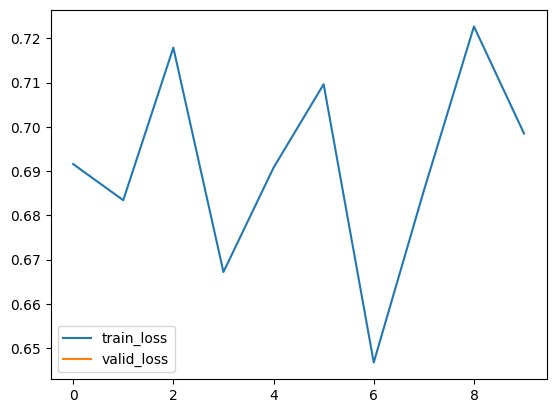

In [15]:
# train_lossとvalid_lossのプロット

plt.plot(grand_train_loss, label="train_loss")
plt.plot(grand_valid_loss, label="valid_loss")
plt.legend()
plt.show()

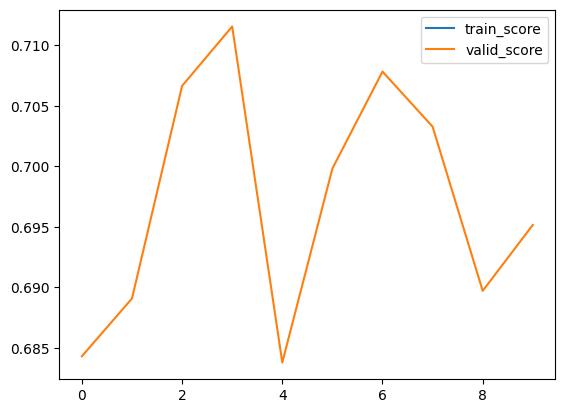

In [16]:
# train_scoreとvalid_scoreのプロット
plt.plot(grand_train_score, label="train_score")
plt.plot(grand_valid_score, label="valid_score")
plt.legend()
plt.show()

In [17]:
random.random()

0.4122630458036113